In [ ]:
!pip install pyts

In [1]:
import os
import pandas as pd
import numpy as np
import multiprocessing
import tensorflow as tf

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    

RND_SEED = 0
GPU_ID = 0
USE_GPU = True

if tf.config.list_physical_devices('GPU') and USE_GPU:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    gpu_name = gpus[0].name  # You may specify an index if using multiple GPUs
    print(f"Using GPU - {gpu_name}")
    device = '/GPU:0'
else:
    device = '/CPU:0'

# To use the device, you can use a context manager in TensorFlow:
with tf.device(device):
    # Your code that uses the specified device
    pass

print(f"Using device {device}")

N_CPU_CORES = multiprocessing.cpu_count()

BASE_FOLDER = os.path.join(
    "..", "input", "tlvmc-parkinsons-freezing-gait-prediction"
)

print(f"Number of CPU cores available: {N_CPU_CORES}")

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 200)

from sklearn.metrics import f1_score
import os
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Using GPU - /physical_device:GPU:0
Using device /GPU:0
Number of CPU cores available: 12


In [2]:
# img_height, img_width = 100, 300

In [2]:
class CustomMultiInputDataGenerator(Sequence):
    def __init__(self, directories, batch_size=32, image_size=(64, 64), shuffle=True, augment=False, num_classes=2, **kwargs):
        """
        directories: List of directories, one for each input branch.
        """
        super().__init__(**kwargs)
        self.directories = directories
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.num_classes = num_classes
        self.image_paths = self._load_image_paths()
        self.samples = len(self.image_paths[0])  # Assume all branches have the same number of images
        
        # Initialize the ImageDataGenerator for augmentation
        self.datagen = ImageDataGenerator(
            rescale=1/255.0,
            width_shift_range=0.1 if self.augment else 0,
            height_shift_range=0.1 if self.augment else 0
        )
        
        self.on_epoch_end()

    def _load_image_paths(self):
        # Load image paths for each branch directory
        image_paths = []
        for directory in self.directories:
            branch_image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.jpg')]
            image_paths.append(branch_image_paths)
        return image_paths

    def _get_class_from_filename(self, filename):
        # Extract label from filename assuming a naming convention
        class_label = int(filename.split('_')[-1].split('.')[0])
        return class_label

    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))

    def __getitem__(self, index):
        # Load a batch of images for each branch
        batch_image_paths = [paths[index * self.batch_size:(index + 1) * self.batch_size] for paths in self.image_paths]
        
        # Load and preprocess images for each branch
        images_per_branch = []
        for branch_paths in batch_image_paths:
            images = np.array([img_to_array(load_img(path, target_size=self.image_size)) for path in branch_paths])
            if self.augment:
                images = np.array([self.datagen.random_transform(image) for image in images])
            else:
                images = self.datagen.standardize(images)
            images_per_branch.append(images)

        # Load labels (assuming the same labels for each branch)
        labels = np.array([self._get_class_from_filename(os.path.basename(path)) for path in batch_image_paths[0]])
        labels = to_categorical(labels, num_classes=self.num_classes)
        
        return images_per_branch, labels

    def on_epoch_end(self):
        if self.shuffle:
            for branch_paths in self.image_paths:
                np.random.shuffle(branch_paths)


In [12]:
from models.cnn_models import create_multi_input_cnn
img_shape = (64, 64)

In [23]:
train_directories = ["data/mean_subtract/gaf_images/AccAP/train", "data/mean_subtract/gaf_images/AccML/train", "data/mean_subtract/gaf_images/AccV/train"]

val_directories = ["data/mean_subtract/gaf_images/AccAP/valid", "data/mean_subtract/gaf_images/AccML/valid", "data/mean_subtract/gaf_images/AccV/valid"]

train_generator = CustomMultiInputDataGenerator(
    directories=train_directories,
    batch_size=32,
    image_size=img_shape,
    augment=False,
    num_classes=2
)

val_generator = CustomMultiInputDataGenerator(
    directories=val_directories,
    batch_size=32,
    image_size=img_shape,
    augment=False,
    num_classes=2
)

model = create_multi_input_cnn()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60
)

Epoch 1/60
259/259 [==============================] - 236s 906ms/step - loss: 1.0834 - accuracy: 0.7140 - precision: 0.7140 - recall: 0.7140 - f1_metric: 0.5945 - val_loss: 1.1049 - val_accuracy: 0.5548 - val_precision: 0.5548 - val_recall: 0.5548 - val_f1_metric: 0.5217
Epoch 2/60
259/259 [==============================] - 67s 256ms/step - loss: 0.8321 - accuracy: 0.7720 - precision: 0.7720 - recall: 0.7720 - f1_metric: 0.6934 - val_loss: 0.8979 - val_accuracy: 0.6257 - val_precision: 0.6257 - val_recall: 0.6257 - val_f1_metric: 0.4979
Epoch 3/60
259/259 [==============================] - 68s 264ms/step - loss: 0.6934 - accuracy: 0.7803 - precision: 0.7803 - recall: 0.7803 - f1_metric: 0.7077 - val_loss: 0.8247 - val_accuracy: 0.6100 - val_precision: 0.6100 - val_recall: 0.6100 - val_f1_metric: 0.5081
Epoch 4/60
259/259 [==============================] - 70s 272ms/step - loss: 0.6128 - accuracy: 0.7852 - precision: 0.7852 - recall: 0.7852 - f1_metric: 0.7130 - val_loss: 0.7058 - val_a

# Save Model

In [ ]:
import pickle

In [ ]:
with open('model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
with open('model_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [ ]:
model.save('multi_input_cnn_model_0_9067_f1score_60_epoch.h5')

# Get Model

In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    # Convert predictions from softmax to class predictions
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    # Cast to float32 for compatibility
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate metrics
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

model = load_model('multi_input_cnn_model_0_9067_f1score_60_epoch.h5', custom_objects={'f1_metric': f1_metric})

# Plot Performance

In [9]:
from matplotlib import pyplot as plt

In [10]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

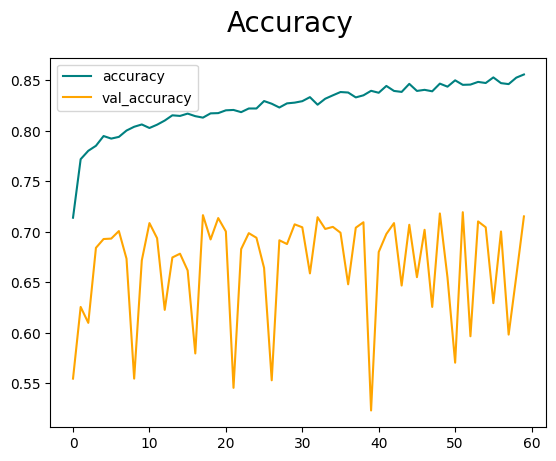

In [25]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
def evaluate_model(model, generator):
    y_true = []
    y_pred = []
    
    for i in range(len(generator)):
        images, batch_y_true = generator[i]
        
        # Get predictions from model
        batch_predictions = model.predict(images, verbose=0)
        
        # Convert softmax output to binary class predictions
        batch_y_pred = np.argmax(batch_predictions, axis=1)
        
        # Flatten ground truth if it's one-hot encoded
        batch_y_true = np.argmax(batch_y_true, axis=1)
        
        y_true.extend(batch_y_true.flatten())
        y_pred.extend(batch_y_pred.flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    metrics = {
        'f1_micro': f1_score(y_true, y_pred, average='micro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_per_class': f1_score(y_true, y_pred, average=None)
    }
    
    return metrics

test_directories = ["data/mean_subtract/gaf_images/AccAP/test", "data/mean_subtract/gaf_images/AccML/test", "data/mean_subtract/gaf_images/AccV/test"]

test_generator = CustomMultiInputDataGenerator(
    directories=test_directories,
    batch_size=32,
    image_size=img_shape,
    augment=False,
    num_classes=2
)

results = evaluate_model(model, test_generator)

print("\nModel Evaluation Results:")
print(f"Micro F1 Score: {results['f1_micro']:.4f}")
print(f"Macro F1 Score: {results['f1_macro']:.4f}")
print(f"Weighted F1 Score: {results['f1_weighted']:.4f}")
print("\nF1 Score per class:")
for i, score in enumerate(results['f1_per_class']):
    print(f"Class {i}: {score:.4f}")


Model Evaluation Results:
Micro F1 Score: 0.8759
Macro F1 Score: 0.8586
Weighted F1 Score: 0.8756

F1 Score per class:
Class 0: 0.8091
Class 1: 0.9081


In [18]:
# test_generator[1]

In [20]:
from sklearn.metrics import confusion_matrix

test_generator.shuffle = False

steps = test_generator.samples // test_generator.batch_size
y_pred = model.predict(test_generator, steps=steps)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator[1]

195/195 [==============================] - 38s 195ms/step


ValueError: Found input variables with inconsistent numbers of samples: [2, 6240]

In [24]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

def evaluate_model(model, generator):
    y_true = []
    y_pred = []
    
    # Loop over the generator to collect all predictions and true labels
    for i in range(len(generator)):
        images, batch_y_true = generator[i]
        
        # Get predictions from the model
        batch_predictions = model.predict(images, verbose=0)
        
        # Convert softmax output to binary class predictions
        batch_y_pred = np.argmax(batch_predictions, axis=1)
        
        # Convert ground truth if it's one-hot encoded
        batch_y_true = np.argmax(batch_y_true, axis=1)
        
        y_true.extend(batch_y_true.flatten())
        y_pred.extend(batch_y_pred.flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Total number of samples
    total_samples = len(y_true)
    
    # Convert counts to percentages
    tn_percent = (tn / total_samples) * 100
    fp_percent = (fp / total_samples) * 100
    fn_percent = (fn / total_samples) * 100
    tp_percent = (tp / total_samples) * 100
    
    # Calculate F1 metrics
    metrics = {
        'f1_micro': f1_score(y_true, y_pred, average='micro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_per_class': f1_score(y_true, y_pred, average=None),
        'true_positives_percentage': tp_percent,
        'true_negatives_percentage': tn_percent,
        'false_positives_percentage': fp_percent,
        'false_negatives_percentage': fn_percent
    }
    
    return metrics

results = evaluate_model(model, test_generator)

print(results)

{'f1_micro': 0.8732214228617107, 'f1_macro': 0.855911585371256, 'f1_weighted': 0.8730856907411674, 'f1_per_class': array([0.80597015, 0.90585302]), 'true_positives_percentage': 60.99120703437249, 'true_negatives_percentage': 26.33093525179856, 'false_positives_percentage': 6.474820143884892, 'false_negatives_percentage': 6.203037569944045}


In [41]:
results = model.evaluate(test_generator)
print(f"Test Results: {results}")

196/196 [==============================] - 39s 196ms/step - loss: 0.4418 - accuracy: 0.8723 - precision: 0.8723 - recall: 0.8723 - f1_metric: 0.9031
Test Results: [0.44175735116004944, 0.872262179851532, 0.872262179851532, 0.872262179851532, 0.9030861854553223]


In [42]:
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

loss: 0.4418
accuracy: 0.8723
precision: 0.8723
recall: 0.8723
f1_metric: 0.9031


In [ ]:
def evaluate_model(model, generator):
    y_true = []
    y_pred = []
    
    for i in range(len(generator)):
        images, batch_y_true = generator[i]
        
        batch_predictions = model.predict(images, verbose=0)
        batch_y_pred = (batch_predictions > 0.4).astype(int)
        
        y_true.extend(batch_y_true.flatten())
        y_pred.extend(batch_y_pred.flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    metrics = {
        'f1_micro': f1_score(y_true, y_pred, average='micro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_per_class': f1_score(y_true, y_pred, average=None)
    }
    
    return metrics


test_generator = CustomDataGenerator("test", augment=False)

results = evaluate_model(model, test_generator)

print("\nModel Evaluation Results:")
print(f"Micro F1 Score: {results['f1_micro']:.4f}")
print(f"Macro F1 Score: {results['f1_macro']:.4f}")
print(f"Weighted F1 Score: {results['f1_weighted']:.4f}")
print("\nF1 Score per class:")
for i, score in enumerate(results['f1_per_class']):
    print(f"Class {i}: {score:.4f}")

In [37]:
train_dir = 'data/mean_subtract/gaf_images/AccML/train'
test_dir = 'data/mean_subtract/gaf_images/AccML/test'
valid_dir = 'data/mean_subtract/gaf_images/AccML/valid'

# Get the list of files in each folder
train_files = set(os.listdir(train_dir))
test_files = set(os.listdir(test_dir))
valid_files = set(os.listdir(valid_dir))

# Find common files
common_files = train_files & test_files & valid_files

# Print or list the common files
print("Common files:", common_files)

Common files: set()


In [45]:
test_files & valid_files

set()

In [39]:
# Define the directory path
directories = {
    "train": 'data/mean_subtract/gaf_images/AccAP/train',
    "valid": 'data/mean_subtract/gaf_images/AccAP/valid',
    "test": 'data/mean_subtract/gaf_images/AccAP/test',
}

for type, dir in directories.items():
    count_1 = 0
    count_0 = 0
    print(f"For {type} ==>")
    for filename in os.listdir(dir):
        if filename.endswith('_1.jpg'):
            count_1 += 1
        elif filename.endswith('_0.jpg'):
            count_0 += 1
    
    # Print the counts
    print(f"class 1: {count_1}")
    print(f"class 0: {count_0}")


For train ==>
class 1: 3182
class 0: 5106
For valid ==>
class 1: 710
class 0: 1700
For test ==>
class 1: 4203
class 0: 2052


In [1]:
import os
import hashlib

def check_duplicate_images(root_dir):
  """
  Checks for duplicate images across train, test, and validation folders.

  Args:
    root_dir: The root directory containing the 'train', 'test', and 'valid' folders.

  Returns:
    A list of tuples, where each tuple contains the paths to two duplicate images.
  """

  duplicates = []
  image_hashes = {}

  for folder in ['train', 'test', 'valid']:
    folder_path = os.path.join(root_dir, folder)
    for filename in os.listdir(folder_path):
      filepath = os.path.join(folder_path, filename)
      with open(filepath, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()
        if file_hash in image_hashes:
          duplicates.append((image_hashes[file_hash], filepath))
        else:
          image_hashes[file_hash] = filepath

  return duplicates

# Example usage:
root_directory = 'data/mean_subtract/gaf_images/AccAP'
duplicate_images = check_duplicate_images(root_directory)

if duplicate_images:
  print("Duplicate images found:")
  for duplicate_pair in duplicate_images:
    print(duplicate_pair)
else:
  print("No duplicate images found.")

Duplicate images found:
('data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_11347_0.jpg', 'data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_12783_0.jpg')
('data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_11347_0.jpg', 'data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_13449_0.jpg')
('data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_11347_0.jpg', 'data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_14065_0.jpg')
('data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_11347_0.jpg', 'data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_15868_0.jpg')
('data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_11347_0.jpg', 'data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_6823_0.jpg')
('data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_11347_0.jpg', 'data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_9103_0.jpg')
('data/mean_subtract/gaf_images/AccAP\\train\\img_AccAP_mean_11347_0.jpg', 'data/mea

2.10.1
